In [1]:
/home/zkytony/Documents/thesis/experiments/deep-semantic-mapping/deepsm/dgsm
%autoreload 2

SyntaxError: invalid syntax (<ipython-input-1-bd6a2a90650e>, line 1)

In [2]:
from deepsm.graphspn.tbm.topo_map import PlaceNode, TopologicalMap
from deepsm.graphspn.tbm.spn_template import NodeTemplateSpn, EdgeRelationTemplateSpn
from deepsm.graphspn.tbm.spn_instance import NodeTemplateInstanceSpn, EdgeRelationTemplateInstanceSpn
from deepsm.graphspn.tbm.template import NodeTemplate, PairTemplate, SingletonTemplate, ThreeNodeTemplate, StarTemplate, \
    EdgeRelationTemplate, ThreeRelTemplate, RelTemplate, SingleRelTemplate, SingleTemplate
from deepsm.graphspn.tbm.algorithm import NodeTemplatePartitionSampler, EdgeRelationPartitionSampler
import numpy as np
import deepsm.util as util
from deepsm.graphspn.tbm.dataset import TopoMapDataset
from deepsm.experiments.common import COLD_ROOT, GRAPHSPN_RESULTS_ROOT, TOPO_MAP_DB_ROOT, GROUNDTRUTH_ROOT
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from pylab import rcParams
import tensorflow as tf
import os, sys
from pprint import pprint

In [3]:
util.CategoryManager.TYPE = "SIMPLE"
util.CategoryManager.init()

db = "Freiburg"

dataset = TopoMapDataset(TOPO_MAP_DB_ROOT)
dataset.load(db, skip_unknown=True, skip_placeholders=True, single_component=True)
coldmgr = util.ColdDatabaseManager(db, COLD_ROOT)

seq_id = "seq3_cloudy1"
topo_map = dataset.get(db, seq_id)

seq1_sunny3 is broken into 2 components
seq1_sunny4 is broken into 2 components


In [4]:
nsampler = NodeTemplatePartitionSampler(topo_map=topo_map)
vsampler = EdgeRelationPartitionSampler(topo_map=topo_map)

sampler = vsampler

### Parameter investigation

Among these parameters, which one has the highest variance across partitions?

In [5]:
# # Randomly partition 500 times
# params = {'complexity':[], 'straight':[], 'dom':[], 'separable':[], 'similarity':[]}
# for i in range(100):
#     p = sampler.random_partition()
#     params['complexity'].append(sampler._complexity(partition=p))
#     params['straight'].append(sampler._straight_template(partition=p))
#     params['dom'].append(sampler._degree_of_middle_node(partition=p))
#     params['separable'].append(sampler._separable_by_middle_node(partition=p))
    
    
# for i in range(20):
#     partitions = []
#     sims = []
#     for j in range(10):
#         p = sampler.random_partition()
#         sims.append(sampler._similarity(partition=p, partitions=partitions))
#         partitions.append(p)
#     params['similarity'].append(np.mean(sims))
    
# # Print statistics for each parameter
# for param in params:
#     print("%s:" % param)
#     print("       mean: %.4f" % np.mean(params[param]))
#     print("        std: %.4f" % np.std(params[param]))
#     print("  coeff-var: %.4f%%" % (np.std(params[param])/np.mean(params[param])*100))
#     print("     median: %.4f" % np.median(params[param]))
#     print("      range: %.4f\n" % (np.max(params[param]) - np.min(params[param])))
#     print("  - exponentiate -\n")
#     print("%s:" % param)
#     exp_params = np.exp(params[param])
#     print("       mean: %.4f" % np.mean(exp_params))
#     print("        std: %.4f" % np.std(exp_params))
#     print("  coeff-var: %.4f%%" % (np.std(exp_params)/np.mean(exp_params)*100))
#     print("     median: %.4f" % np.median(exp_params))
#     print("      range: %.4f" % (np.max(exp_params) - np.min(exp_params)))
#     print("-------------------")

separable:
       mean: 0.0340
        std: 0.0224
  coeff-var: 65.8788%
     median: 0.0417
      range: 0.0833

  - exponentiate -

separable:
       mean: 1.0348
        std: 0.0232
  coeff-var: 2.2396%
     median: 1.0425
      range: 0.0869
-------------------
similarity:
       mean: 0.0358
        std: 0.0085
  coeff-var: 23.7591%
     median: 0.0382
      range: 0.0310

  - exponentiate -

similarity:
       mean: 1.0365
        std: 0.0088
  coeff-var: 0.8502%
     median: 1.0390
      range: 0.0322
-------------------
complexity:
       mean: 10.9725
        std: 0.2935
  coeff-var: 2.6745%
     median: 10.8750
      range: 1.1250

  - exponentiate -

complexity:
       mean: 60805.0399
        std: 18016.1599
  coeff-var: 29.6294%
     median: 52838.7446
      range: 75544.1205
-------------------
straight:
       mean: 0.1020
        std: 0.0794
  coeff-var: 77.9174%
     median: 0.0769
      range: 0.3077

  - exponentiate -

straight:
       mean: 1.1109
        std: 0.08

In [11]:
# Parameters
params = {
    'similarity_coeff': -0.5,
    'complexity_coeff': 3,
    'straight_template_coeff': 10,
    'dom_coeff': 3,
    'separable_coeff': 10
}
sampler.set_params(**params)

In [12]:
def factor_correlations(factor_names, num_rounds=20, num_partitions=5,
                        params=None, plot=False, dbs=['Stockholm', 'Freiburg', 'Saarbrucken'], num_seqs=10):
    """Sample a bunch of partitions. Then, for each parameter, plot each partition's value for that parameter
    versus the partition's energy. See if they correlate in the way we want.
    
    Returns a dictionary of the format:
    
        factor name -> {
            db_name -> {
                factor_name -> correlation_coefficient
            }
            _average_ -> average correlation coefficient
        }
    
    that maps from factor name to correlation coefficient of that factor to energy.
    """
    def corr_plot(ax, x, y, xlabel):
        ax.scatter(x, y)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("energy")
    
    result = {}
    dataset = TopoMapDataset(TOPO_MAP_DB_ROOT)
                             
    for db in dbs:
        print("On DB %s" % db)
        dataset.load(db, skip_unknown=True, skip_placeholders=True, single_component=True)
        topo_maps = dataset.get_topo_maps(db_name=db, amount=num_seqs)
        
        x = {}
        y = {}
    
        for seq_id in topo_maps:
            topo_map = topo_maps[seq_id]
            sampler = NodeTemplatePartitionSampler(topo_map=topo_map)
            if params is not None:
                sampler.set_params(**params)

            partition_sets, attributes = sampler.sample_partition_sets(num_rounds, num_partitions)

            for i in range(len(partition_sets)):
                for f in factor_names:
                    if f not in x:
                        x[f] = []
                        y[f] = []
                    for j, p in enumerate(partition_sets[i]):
                        attr = attributes[i]
                        if f in attr['factors'][j]:
                            x[f].append(attr['factors'][j][f])
                            y[f].append(attr['energies'][j])
                            
        if plot:
            fig, axes = plt.subplots(len(factor_names)//3+1, 3, sharey=True)
            fig.suptitle('%s' % db)
            for i, p in enumerate(factor_names):
                # Plot
                corr_plot(axes[i//3,i%3], x[p], y[p], p)
                
                
        # Compute correlation coefficent
        for f in factor_names:
            if f not in result:
                result[f] = {}
            result[f][db] = np.corrcoef(x[f], y[f])
            
    for f in factor_names:
        result[f]['_average_'] = np.mean([result[f][db] for db in dbs])
    return result

In [13]:
def random_search(params, ranges, desired, factor_names,
                  rounds=50, **fc_params):
    """Goal is to find a set of parameters that best separate the
    different partitions, and maximize desired correlation with
    the energy.
    
    The ith element in `desired` should be 1 if we hope the ith
    parameter to have a positive correlation with the energy. -1
    if otherwise.
    
    The ith element in prarams should be the coefficient for the
    ith element in factor_names.
    """
    best_setting = {}
    best_corrs = {}
    lowest_avg_gap = float('inf')
    for r in range(rounds):
        sys.stdout.write('*** round %d/%d ***\n' % (r+1, rounds)); sys.stdout.flush()
        setting = {}
        gaps = []
        for i in range(len(params)):
            setting[params[i]] = np.random.uniform(low=ranges[i][0], high=ranges[i][1])
        print(setting)
        
        corrs = factor_correlations(factor_names, **fc_params)
        for i in range(len(params)):
            f = factor_names[i]
            gaps.append(abs(desired[i] - corrs[f]['_average_']))
        
        avg_gap = np.mean(gaps)
        if avg_gap < lowest_avg_gap:
            lowest_averge_gap = avg_gap
            best_setting = setting
            best_corrs = corrs
            
    return best_setting, best_corrs, lowest_avg_gap
    

In [14]:
factor_names=['complexity', 'straight', 'dom', 'separable', 'similarity']
params = ['similarity_coeff', 'complexity_coeff', 'straight_template_coeff', 'dom_coeff', 'separable_coeff']
ranges = [(-1, 1), (0, 0), (0, 0), (0, 0), (0, 2)]
desired = [1, -1, -1, -1, -1]

In [15]:
# best_setting, best_corrs, lowest_avg_gap = random_search(params, ranges, desired, factor_names, rounds=200, num_seqs=5,
#                                                         dbs=['Stockholm', 'Freiburg', 'Saarbrucken'], num_rounds=10)

On DB Stockholm
floor4_cloudy_a1 is broken into 2 components
floor4_cloudy_a2 is broken into 2 components
floor4_cloudy_b is broken into 2 components
floor4_cloudy_c is broken into 2 components
floor4_night_a1 is broken into 2 components
floor4_night_a2 is broken into 2 components
floor4_night_b is broken into 2 components
floor4_night_c is broken into 2 components
floor6_cloudy_a1 is broken into 2 components
floor6_cloudy_a2 is broken into 2 components
floor6_cloudy_b is broken into 2 components
floor6_cloudy_c is broken into 2 components
floor6_night_a1 is broken into 2 components
floor6_night_a2 is broken into 2 components
floor6_night_b is broken into 2 components
floor6_night_c is broken into 2 components
floor7_cloudy_c is broken into 2 components
floor7_night_c is broken into 2 components
round 5/5
round 5/5
round 5/5
round 5/5
round 5/5
On DB Freiburg
seq1_sunny3 is broken into 2 components
seq1_sunny4 is broken into 2 components
round 5/5
round 5/5
round 5/5
round 5/5
On DB Sa

{'complexity': {'Freiburg': array([[ 1.        ,  0.00489542],
         [ 0.00489542,  1.        ]]),
  'Saarbrucken': array([[ 1.       ,  0.0829805],
         [ 0.0829805,  1.       ]]),
  'Stockholm': array([[ 1.        ,  0.03712377],
         [ 0.03712377,  1.        ]]),
  '_average_': 0.52083328323942668},
 'dom': {'Freiburg': array([[ 1.       , -0.0951745],
         [-0.0951745,  1.       ]]),
  'Saarbrucken': array([[ 1.        , -0.14946068],
         [-0.14946068,  1.        ]]),
  'Stockholm': array([[ 1.       , -0.0206829],
         [-0.0206829,  1.       ]]),
  '_average_': 0.45578031907334443},
 'separable': {'Freiburg': array([[ 1.        , -0.44657339],
         [-0.44657339,  1.        ]]),
  'Saarbrucken': array([[ 1.        , -0.51672629],
         [-0.51672629,  1.        ]]),
  'Stockholm': array([[ 1.        , -0.39260233],
         [-0.39260233,  1.        ]]),
  '_average_': 0.2740163327998138},
 'similarity': {'Freiburg': array([[ 1.        ,  0.81707045],
 

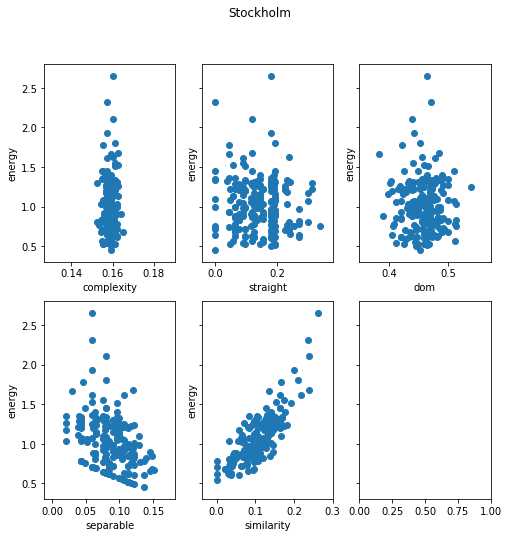

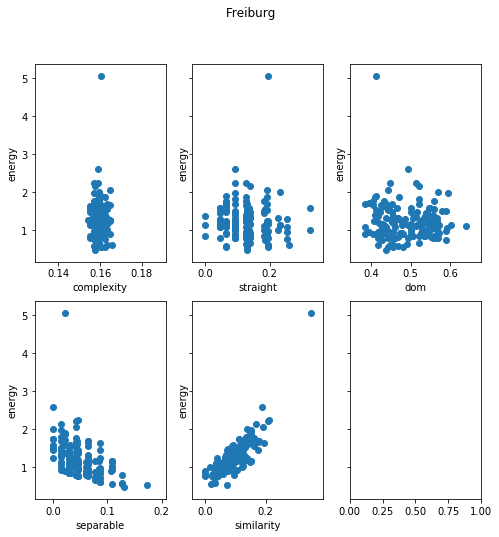

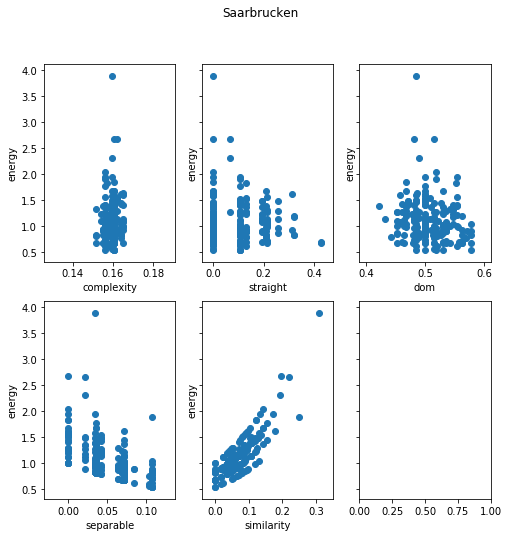

In [16]:
rcParams['figure.figsize'] = 8, 8
setting = {'straight_template_coeff': 0.0,
           'separable_coeff': 5.73417749181195,
           'complexity_coeff': 0.0,
           'similarity_coeff': -5.01456560135485,
           'dom_coeff': 0.0}
factor_correlations(factor_names, num_rounds=5, num_partitions=8, num_seqs=5,
                    params=setting, plot=True, dbs=['Stockholm', 'Freiburg', 'Saarbrucken'])

In [17]:

sampler.set_params(**setting)

### Energy Distribution

In [18]:
# partition_sets, attributes = sampler.sample_partition_sets(15, 10)
# energies = [attributes[i]['energies'] for i in range(len(attributes))]
# exponents = [-np.log(energies[i]) for i in range(len(energies))]

In [19]:
# Plot
def energy_plot(ax, exponents, energies, label="partition"):
    ax.scatter(exponents, energies, label=label)
    ax.set_xlabel("exponent")
    ax.set_ylabel("energy")
    ax.axhline(y=np.mean(energies), color='orange', label='mean=%.3f' % (np.mean(energies)))

In [20]:
# rcParams['figure.figsize'] = 15, 20

# f, axes = plt.subplots(len(energies)//3, 3, sharey=True)

# for i in range(len(energies)):
#     energy_plot(axes[i//3, i%3], exponents[i], energies[i], label="partitoin_set %d" % (i))
#     axes[i//3, i%3].legend(loc='upper right')
# plt.show()

### Select Best Partitions

In [21]:
# # Use partition with lowest median
# # partition_sets, energies, exponents = sample_partition_sets(10, 15, use_object_method=False)
# def order(partition_sets, energies):
#     indices = sorted(range(len(energies)), key=lambda i:np.median(energies[i]))
#     return indices

In [22]:
# indices = order(partition_sets, energies)
# top_partition_set = partition_sets[indices[0]]

# rcParams['figure.figsize'] = 5, 4
# energy_plot(plt.gca(), exponents[indices[0]], energies[indices[0]], label='partition %d' % indices[0])
# plt.legend(loc='upper right')
# plt.show()

In [23]:
# # Visualize
# rcParams['figure.figsize'] = 22, 14
# for i, partition in enumerate(top_partition_set):
#     sampler.visualize_partition(partition, coldmgr.groundtruth_file(seq_id.split("_")[0], 'map.yaml'))
#     plt.savefig('partitions/%s-%d.png' % (seq_id, i))
#     plt.clf()
#     print("partitions/Saved %s-%d.png" % (seq_id, i))

### Random Partitions

In [24]:
# os.makedirs("partitions/random", exist_ok=True)
# partitions = []
# energies = []
# exponents = []
# rcParams['figure.figsize'] = 22, 14
# for i in range(10):
#     p = sampler.random_partition()
#     e, _ = sampler.energy(partition=p, partitions=partitions)
#     energies.append(e)
#     exponents.append(-np.log(e))
    
#     sampler.visualize_partition(p, coldmgr.groundtruth_file(seq_id.split("_")[0], 'map.yaml'))
#     plt.savefig('partitions/random/%s-%d.png' % (seq_id, i))
#     plt.clf()
#     print("partitions/random Saved %s-%d.png" % (seq_id, i))
#     partitions.append(p)

In [25]:
# rcParams['figure.figsize'] = 5, 4
# energy_plot(plt.gca(), exponents, energies, label='random')
# plt.legend(loc='upper right')
# plt.show()

## Sample More

In [26]:
partition_sets, attributes, best_index = sampler.sample_partition_sets(100, 5, pick_best=True)
top_pset = partition_sets[best_index]
attributes = attributes[best_index]

round 100/100


In [27]:
energies = attributes['energies']
exponents = [-np.log(e) for e in energies]

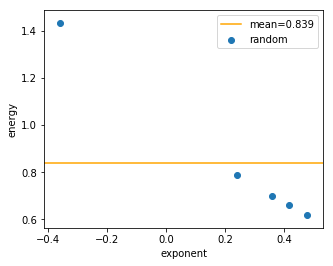

In [28]:
rcParams['figure.figsize'] = 5, 4
energy_plot(plt.gca(), exponents, energies, label='random')
plt.legend(loc='upper right')
plt.show()

## Try it on GraphSPN

In [29]:
# Construct GraphSPN from partitions

import yaml
with open("likelihoods/likelihoods_Freiburg_seq3_cloudy1.yaml") as f:
    dgsm_lh = yaml.load(f)['likelihoods']
    
### Build graphspn

sess = tf.Session()

if type(sampler) == NodeTemplatePartitionSampler:
    print("Node template")
    tspn3 = NodeTemplateSpn(ThreeNodeTemplate, seed=100)
    tspn2 = NodeTemplateSpn(PairTemplate, seed=100)
    tspn1 = NodeTemplateSpn(SingletonTemplate, seed=100)

    #### Load Template SPNs from files
    spn3_path = "models/ThreeNodeTemplate_4_Freiburg12.spn"
    spn2_path = "models/PairTemplate_4_Freiburg12.spn"
    spn1_path = "models/SingletonTemplate_4_Freiburg12.spn"
    
    tspn3.load(spn3_path, sess)
    tspn2.load(spn2_path, sess)
    tspn1.load(spn1_path, sess)
    
    tspns = [(tspn3, ThreeNodeTemplate), (tspn2, PairTemplate), (tspn1, SingletonTemplate)]
    
    for template_spn, _ in tspns:
        template_spn._conc_inputs.set_inputs()
    ispn = NodeTemplateInstanceSpn(topo_map, sess, *tspns, partitions=top_pset,
                               seq_id=seq_id, divisions=8, db_name="Freiburg", visualize_partitions_dirpath="./partitions")

else:
    print("View template")
    tspn4 = EdgeRelationTemplateSpn(ThreeRelTemplate, seed=100)
    tspn3 = EdgeRelationTemplateSpn(SingleRelTemplate, seed=100)
    tspn2 = EdgeRelationTemplateSpn(SingleTemplate, seed=100)
    tspn1 = EdgeRelationTemplateSpn(RelTemplate, seed=100)

    #### Load Template SPNs from files
    spn4_path = "models/ThreeRelTemplate_4_Freiburg12.spn"
    spn3_path = "models/SingleRelTemplate_4_Freiburg12.spn"
    spn2_path = "models/SingleTemplate_4_Freiburg12.spn"
    spn1_path = "models/RelTemplate_4_Freiburg12.spn"
    
    tspn4.load(spn4_path, sess)
    tspn3.load(spn3_path, sess)
    tspn2.load(spn2_path, sess)
    tspn1.load(spn1_path, sess)
    
    tspns = [(tspn4, ThreeRelTemplate), (tspn3, SingleRelTemplate), (tspn2, SingleTemplate), (tspn1, RelTemplate)]
    for template_spn, _ in tspns:
        template_spn._conc_inputs.set_inputs()
    ispn = EdgeRelationTemplateInstanceSpn(topo_map, sess, *tspns, partitions=top_pset,
                               seq_id=seq_id, divisions=8, db_name="Freiburg", visualize_partitions_dirpath="./partitions")

sess.run(tspn1.root.weights.node.get_value())

ispn.expand()

ispn.init_ops(no_mpe=True)

query_nids = [nid for nid in topo_map.nodes]
query = {nid:-1 for nid in topo_map.nodes}
query_lh = dgsm_lh
marginals = ispn.marginal_inference(sess, query_nids, query, query_lh=query_lh)

true_catg_map = topo_map.current_category_map()
result_catg_map = {}
query_catg_map = {}
for nid in query:
    result_catg_map[nid] = marginals[nid].index(max(marginals[nid]))
    query_catg_map[nid] = query_lh[nid].tolist().index(max(query_lh[nid]))

floor = seq_id.split("_")[0]
topo_map.assign_categories(true_catg_map)



[INFO] [spn.JSONLoader:load] Loading SPN graph from file 'models/ThreeRelTemplate_4_Freiburg12.spn'


View template
Instructions for updating:
keep_dims is deprecated, use keepdims instead


[WARNING] [tensorflow:warning] From /home/zkytony/Documents/thesis/experiments/libspn/libspn/utils/math.py:466: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
[INFO] [spn.JSONLoader:load] Loading SPN graph from file 'models/SingleRelTemplate_4_Freiburg12.spn'
[INFO] [spn.JSONLoader:load] Loading SPN graph from file 'models/SingleTemplate_4_Freiburg12.spn'
[INFO] [spn.JSONLoader:load] Loading SPN graph from file 'models/RelTemplate_4_Freiburg12.spn'


Importing matplotlib...
Partition 1
Duplicating (0, 1)... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

/home/zkytony/Documents/thesis/experiments/deep-semantic-mapping/deepsm/graphspn/tbm/spn_instance.py:591: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/zkytony/py3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zkytony/py3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zkytony/py3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start

22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 
Duplicati

In [30]:

# Visualize
def vis_map(topo_map, floor, catg_map):
    topo_map.assign_categories(catg_map)
    rcParams['figure.figsize'] = 22, 14
    topo_map.visualize(plt.gca(), coldmgr.groundtruth_file(floor, 'map.yaml'), consider_placeholders=False)

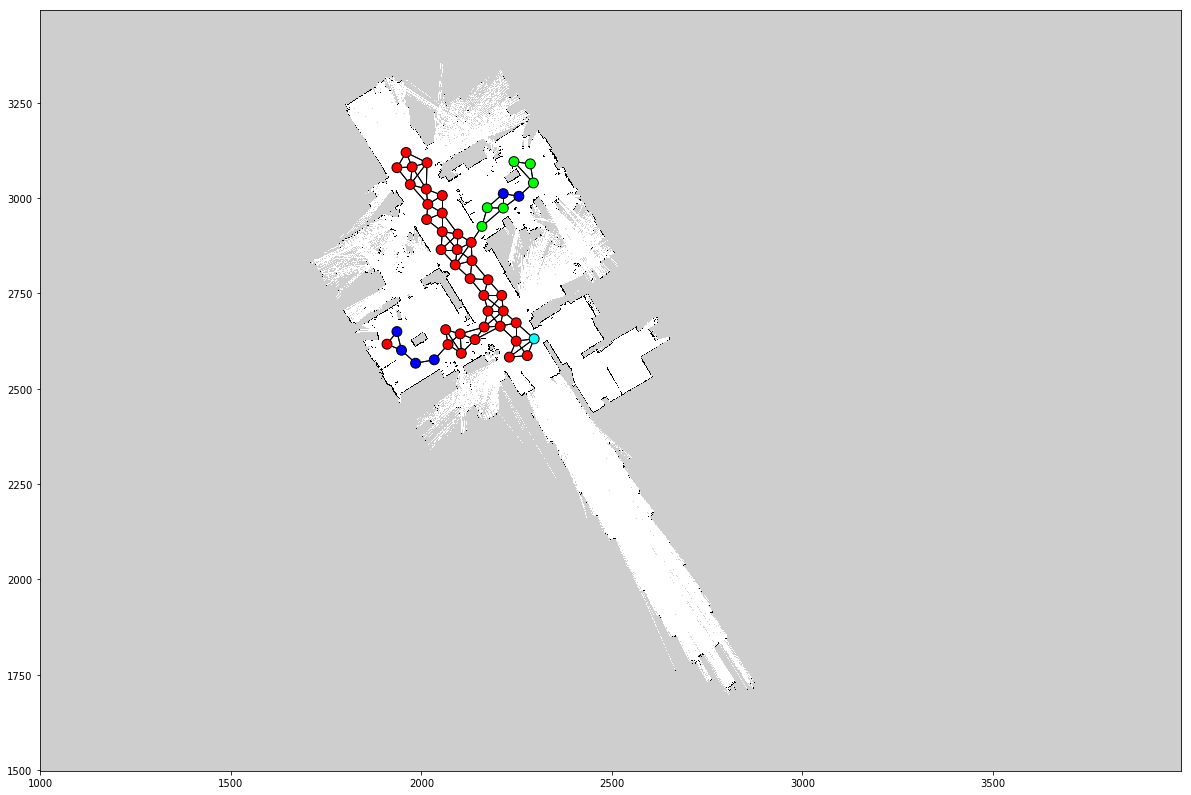

In [31]:
vis_map(topo_map, floor, result_catg_map)

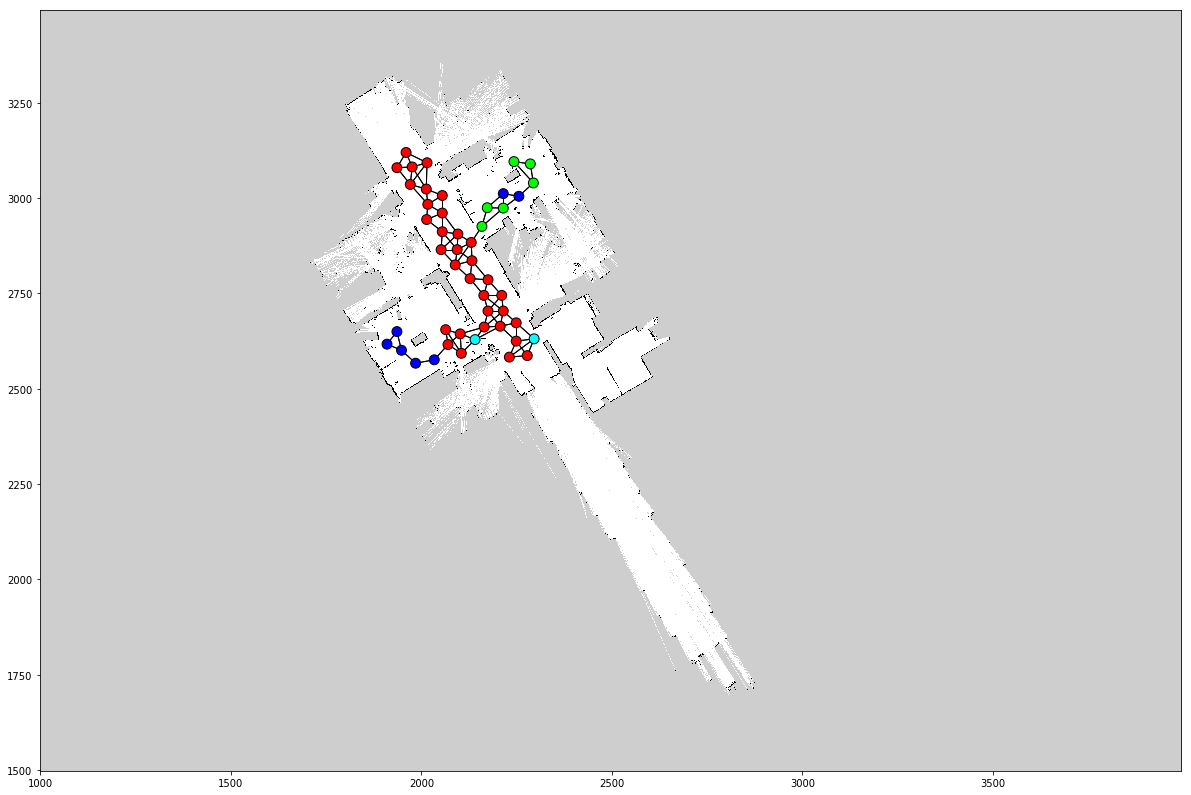

In [20]:
vis_map(topo_map, floor, query_catg_map)